## Task A

* **Write the covariance Q;**

`run.py`:

    
        parser.add_argument('-b',
                        '--bearing_std',
                        type=float,
                        action='store',
                        help='Diagonal of Standard deviations of the Observation noise Q. (format: rad).',
                        default=0.35)
    
$Q = \begin{bmatrix} \sigma_{\phi}^2 \end{bmatrix} $, $\sigma_{\phi}^2$ = `bearing_std` = 0.35.

* **Write the equation for the covariance R_t;**

For odometry motion model we have $\epsilon_t = \begin{bmatrix} \epsilon_{\delta_{rot1}} \\ \epsilon_{\delta_{trans}} \\ \epsilon_{\delta_{rot2}} \end{bmatrix} \sim \mathcal{N}\left(0, \begin{bmatrix}\alpha_1\delta_{rot1}^2 + \alpha_2\delta_{trans}^2 && 0 && 0 \\ 0 && \alpha_3\delta_{trans}^2 + \alpha_4(\delta_{rot1}^2 + \delta_{rot2}^2) && 0 \\ 0 && 0 && \alpha_1\delta_{rot2}^2 + \alpha_2\delta_{trans}^2 \end{bmatrix}\right)$

As initial command $u = \left[\delta_{rot1}, \delta_{trans}, \delta_{rot2}\right]^{\top} = [0, 10, 0]^{\top}$ and default values of alphas $\alpha_{1 \dots 4} = (0.05, 0.001, 0.05, 0.01)$, then $R = \begin{bmatrix}100\alpha_2 && 0 && 0 \\ 0 && 100\alpha_3 && 0 \\ 0 && 0 && 100\alpha_2 \end{bmatrix} = \begin{bmatrix} 0.1 && 0 && 0 \\ 0 && 5.0 && 0 \\ 0 && 0 && 0.1 \end{bmatrix};$

* **Derive the equations for the Jacobians $G_t, V_t$ and $H_t$**

![taskA](task_A_jacob.jpg "taskA")

## Task C

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from tools.task import wrap_angle
from IPython.display import Video

In [157]:
def plot_errors(real_traj, pred_traj, cov, num_steps):
    error = real_traj - pred_traj
    for i, er in enumerate(error[:, -1]):
        if er < -np.pi or er > np.pi:
            error[i, -1] = wrap_angle(er)

    fig, axs = plt.subplots(1, 3, figsize=(25, 7))
    labels = [r'$\hat{x} - x$', r'$\hat{y} - y$', r'$\hat{z} - z$']
    titles = ['pose error x', 'pose error y', 'pose error theta']

    for i in range(error.shape[-1]):
        axs[i].plot(np.arange(num_steps), error[:, i], label=labels[i])
        axs[i].fill_between(np.arange(num_steps), -3*np.sqrt(cov[i]), 3*np.sqrt(cov[i]), color='red', alpha=0.5, label='$\pm$3sigma')
        axs[i].grid('on')
        axs[i].set_title(titles[i], fontsize=18)
        axs[i].set_xlabel('timestep', fontsize=18)
        axs[i].set_ylabel('error value', fontsize=18)
        axs[i].legend(fontsize=14)
        
def load_data(filename_gt, filename_predict):
    input_data = np.load(filename_gt)
    output = np.load(filename_predict)

    covariance_matrices = output['covariance_trajectory']
    covs = np.array([np.diag(covariance_matrices[:, :, i]) for i in range(covariance_matrices.shape[-1])]).T
    return input_data, output, covs


In [190]:
filename_gt = './out_ekf/input_data.npy'
filename_predict_pf = './out_pf/output_data.npy'
filename_predict_ekf = './out_ekf/output_data.npy'

In [191]:
input_data, output_ekf, covs_ekf = load_data(filename_gt, filename_predict_ekf)
input_data, output_pf, covs_pf = load_data(filename_gt, filename_predict_pf)

### Extended Kalman Filter

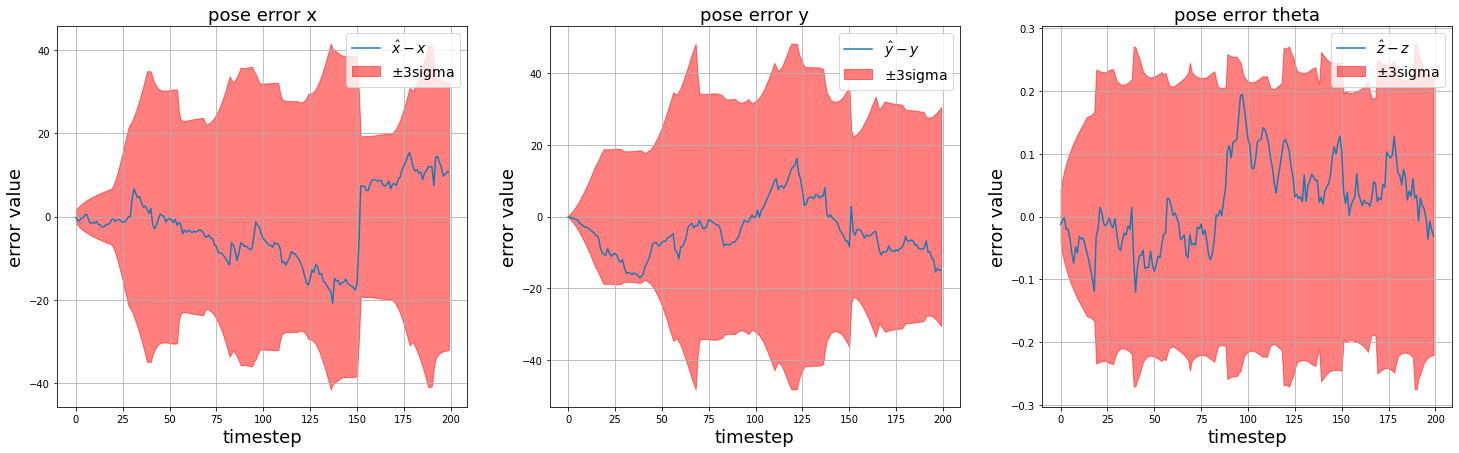

In [133]:
plot_errors(input_data['real_robot_path'], output_ekf['mean_trajectory'], 
            covs_ekf, input_data['num_steps'])


In [141]:
Video('./ekf-video.mp4', width=700)

### Particle filter num_particles=100

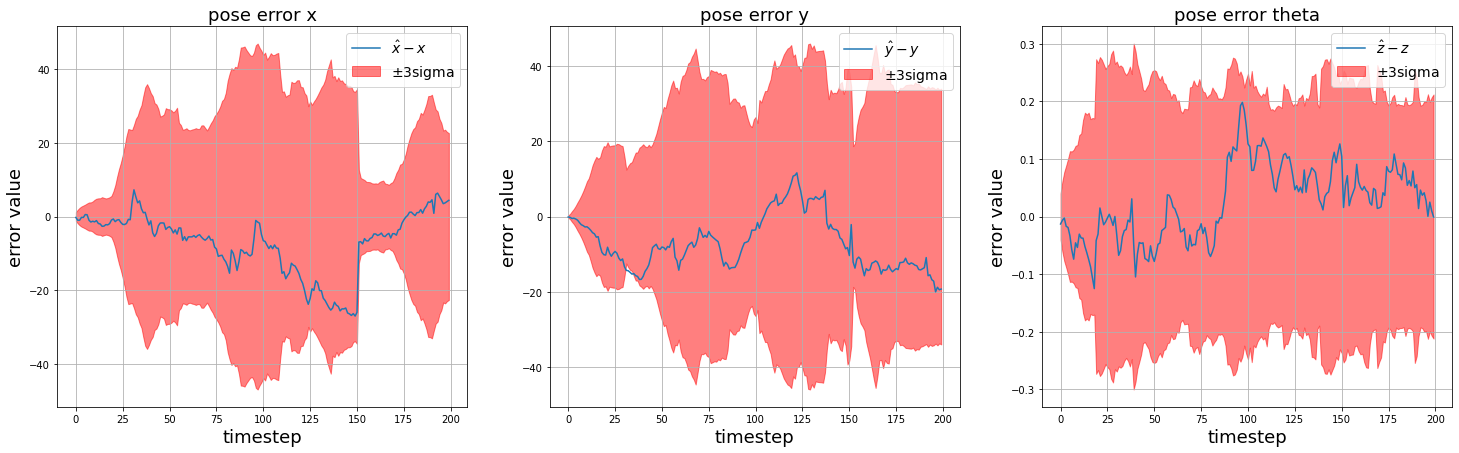

In [192]:
plot_errors(input_data['real_robot_path'], output_pf['mean_trajectory'], 
            covs_pf, input_data['num_steps'])


In [195]:
Video('./PF-video.mp4', width=700)

## Task D

* **The sensor or motion noise go toward zero (Q matrix and R matrix)**

In [143]:
bearing_std = 0.01 # => Q goes to zero

In [172]:
filename_gt = './out_ekf_0_01/input_data.npy'
filename_predict = './out_ekf_0_01/output_data.npy'
input_data, output_qzero, covs_qzero = load_data(filename_gt, filename_predict)

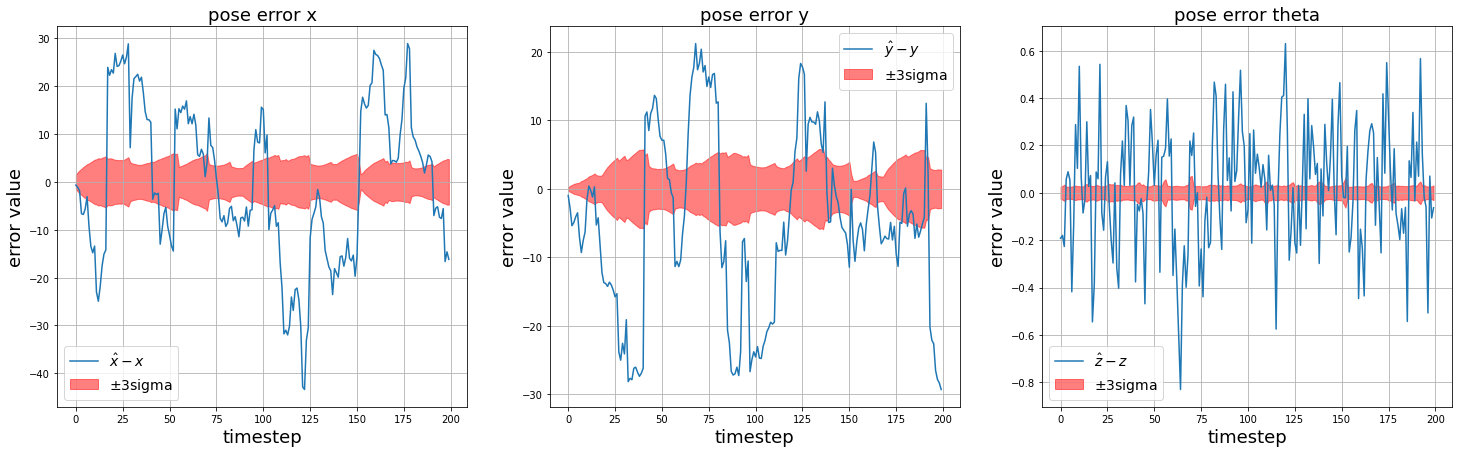

In [173]:
plot_errors(input_data['real_robot_path'], output_qzero['mean_trajectory'], 
            covs_qzero, input_data['num_steps'])

**Q matrix goes to zero**

Final trajectory
![Q matrix goes to zero](bearing_std_001.png "Q matrix goes to zero")

**Comment:** for the low Q matrix model doesn't take into account sensor's noise, it supposes that the observations are more precise than they are in reality. The 3sigma region shrinked what means that model supposes it's predictions are closer to the true robot positions. However, the real robot positions deviated from this optimistic predictions greater than before excluding Q matrix, so error increased. Also, because the noise is excluded model cannot compensate the deviations in the observed values.  It doesn't add stabilisation in the motion so it starts to move inconsisnetly with a lot of twitchy movements.

In [174]:
alphas = (0.001, 0.0001, 0.001, 0.001) # => R matrix goes to zero

In [180]:
filename_gt = './out_ekf_rzero/input_data.npy'
filename_predict = './out_ekf_rzero/output_data.npy'
input_data, output_rzero, covs_rzero = load_data(filename_gt, filename_predict)

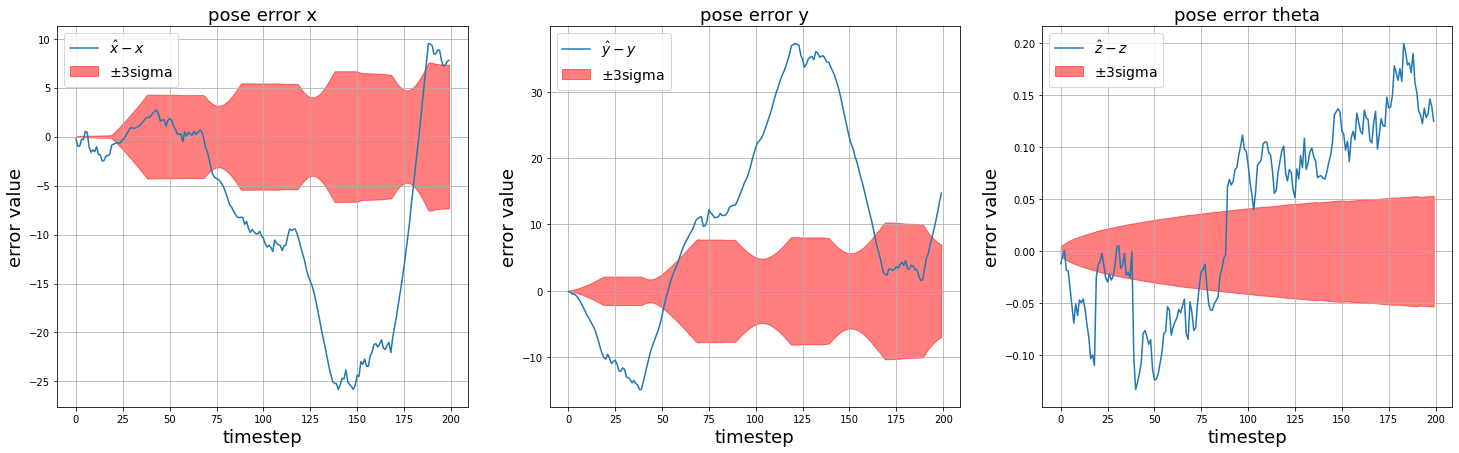

In [181]:
plot_errors(input_data['real_robot_path'], output_rzero['mean_trajectory'], 
            covs_rzero, input_data['num_steps'])

**R matrix goes to zero**

Final trajectory
![R matrix goes to zero](rzero.png "R matrix goes to zero")

**Comment:** for the low R matrix model doesn't take into account motion noise so it ignores deviations in the transition fuction and follows the described odometry sequence. This way it preserves the constant deviation from the real shifted trajectory.


* **Number of particles decrease** (num_particles = [150, 30, 15])

In [199]:
filename_gt = './out_pf_150/input_data.npy'
filename_predict = './out_pf_150/output_data.npy'
input_data, output_n150, covs_n150 = load_data(filename_gt, filename_predict)

**Number of particles 150**

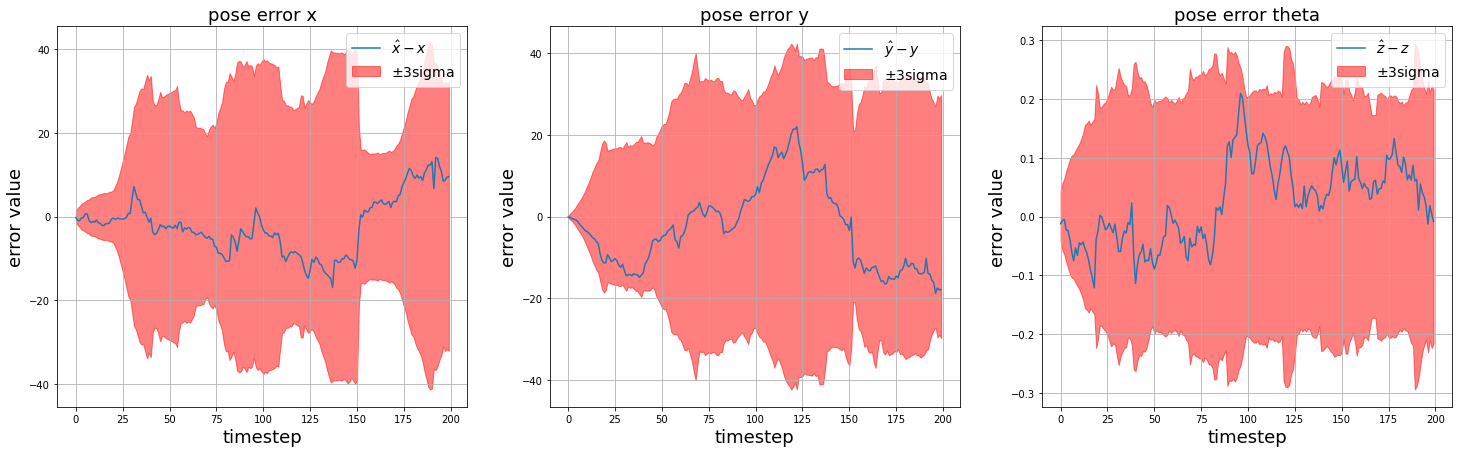

In [200]:
plot_errors(input_data['real_robot_path'], output_n150['mean_trajectory'], 
            covs_n150, input_data['num_steps'])

In [201]:
Video('./particles_150.mp4', width=700)

In [182]:
filename_gt = './out_pf_30/input_data.npy'
filename_predict = './out_pf_30/output_data.npy'
input_data, output_n30, covs_n30 = load_data(filename_gt, filename_predict)

**Number of particles = 30**

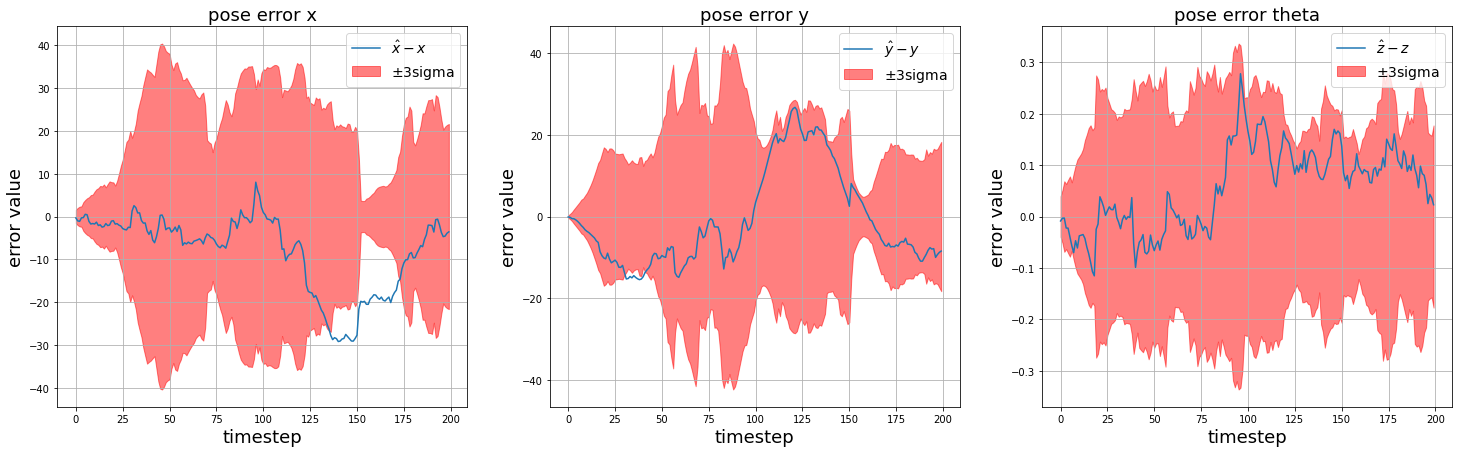

In [184]:
plot_errors(input_data['real_robot_path'], output_n30['mean_trajectory'], 
            covs_n30, input_data['num_steps'])


Final trajectory
![Number of particles = 30](num_part_30.png "--num-particles 30")

In [185]:
filename_gt = './out_pf_15/input_data.npy'
filename_predict = './out_pf_15/output_data.npy'
input_data, output_n15, covs_n15 = load_data(filename_gt, filename_predict)

**Number of particles = 15**

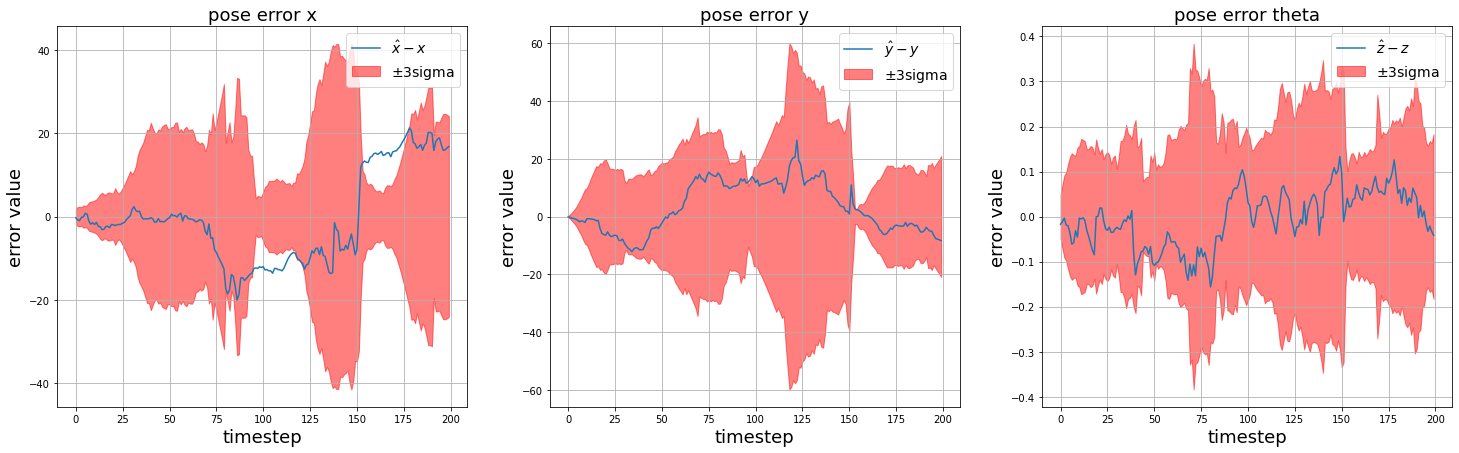

In [186]:
plot_errors(input_data['real_robot_path'], output_n15['mean_trajectory'], 
            covs_n15, input_data['num_steps'])

Final trajectory
![Number of particles = 15](num_part_15.png "--num-particles 15")

**Comments:** We can observe that number of particles influences the accuracy of the trajectory estimation, the more particles we use the closer alignment we get. However number of particles increases computation time quite significantly, so here we have some tradeoff.

(for some trajectories forgot to show particles, sorry for that!)

* **if the filter noise parameters underestimate or overestimate the true noise parameters? Please clarify what underestimation and overestimation of noise is?**

Lets try to increase (decrease) Q and R matrices simultaneously and see what results we will get. The under(over)estimation means that model uses lower (greater) coefficients to include described noise values with lower (greater) weights in the algorithm.


**Underestimate**
Underestimate => smaller covariance ellips what means that model is less confident in greater number of possible future positions, the uncertanty increases. Regarding the trajectory we observe than model predicts somewhere in between of low noise for odometry model (it thinks that optimistic odometry motion is correct) and low sensor noise (varying sensor predictions are correct) so it has inconsistent fluctuations due to observations but stays closer to the odometry path.
![Number of particles = 15](underestimate.png "--num-particles 15")

**Overestimate**
Overestimate => larger covariance ellips what means that model becomes less sure in the trajectory, so it goes crasy and starts to move more freely as the noise was larger than it is in reality. We loose the filtering of the impossible future positions, the quality of predictions decreases drastically.
![Number of particles = 15](overestimate.png "--num-particles 15")

In [197]:
Video('./ekf-underestimage.mp4', width=700)

In [196]:
Video('./ekf-overestimage.mp4', width=700)